In [9]:
# Cell 1: Setup and Download
!pip install -q kagglehub

import kagglehub
import os
import shutil
import glob

# Download dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("akilesh253/sugarcane-plant-diseases-dataset")
print(f"Dataset downloaded to: {path}")

# --- FIX: ROBUST FOLDER SEARCH ---
print("\n--- Scanning Directory Structure ---")
target_folder_name = "redrot" # We will normalize everything to lowercase/no-spaces
red_rot_path = None

for root, dirs, files in os.walk(path):
    for dir_name in dirs:
        # Create a "normalized" name (lowercase, remove spaces and underscores)
        normalized_name = dir_name.lower().replace(" ", "").replace("_", "")

        # Check if it matches 'redrot'
        if "redrot" in normalized_name:
            full_path = os.path.join(root, dir_name)
            # double check it has images
            if len(glob.glob(os.path.join(full_path, "*"))) > 0:
                red_rot_path = full_path
                print(f"FOUND MATCH: {dir_name} -> {red_rot_path}")
                break
    if red_rot_path:
        break

if red_rot_path:
    print(f"\nSUCCESS: Target Disease Folder Found at: {red_rot_path}")
    # Verify count
    count = len(glob.glob(os.path.join(red_rot_path, "*")))
    print(f"Contains {count} images.")
else:
    # DEBUG: If it still fails, print all folders so we can see what went wrong
    print("\nERROR: Still could not find the folder. Listing all found folders:")
    for root, dirs, files in os.walk(path):
        for d in dirs:
            print(f"- {d}")
    raise ValueError("Could not find 'Red Rot' folder. Check the list above.")

Dataset downloaded to: /kaggle/input/sugarcane-plant-diseases-dataset

--- Scanning Directory Structure ---
FOUND MATCH: RedRot -> /kaggle/input/sugarcane-plant-diseases-dataset/Sugarcane_leafs/RedRot

SUCCESS: Target Disease Folder Found at: /kaggle/input/sugarcane-plant-diseases-dataset/Sugarcane_leafs/RedRot
Contains 3108 images.


In [10]:
# Cell 2: Auto-Sort Data into Mild vs Severe Domains
import cv2
import numpy as np
from tqdm import tqdm
import os
import shutil
import glob

# Define paths for our new sorted dataset
base_dir = "dataset_prognosis"
mild_dir = os.path.join(base_dir, "mild")
severe_dir = os.path.join(base_dir, "severe")

# Clean reset
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.makedirs(mild_dir)
os.makedirs(severe_dir)

def calculate_infection_ratio(image_path):
    img = cv2.imread(image_path)
    if img is None: return None

    # Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Masks for Disease (Red/Brown/Yellowish spots)
    lower_red1, upper_red1 = np.array([0, 50, 50]), np.array([20, 255, 255])
    lower_red2, upper_red2 = np.array([160, 50, 50]), np.array([180, 255, 255])
    lower_yellow, upper_yellow = np.array([20, 50, 50]), np.array([35, 255, 255])

    mask = cv2.inRange(hsv, lower_red1, upper_red1) + \
           cv2.inRange(hsv, lower_red2, upper_red2) + \
           cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Mask for Leaf (Green)
    lower_green, upper_green = np.array([35, 40, 40]), np.array([85, 255, 255])
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    # Infection Ratio = Diseased Pixels / (Diseased + Healthy Pixels)
    disease_pixels = cv2.countNonZero(mask)
    leaf_pixels = cv2.countNonZero(mask_green) + disease_pixels

    if leaf_pixels == 0: return 0
    return disease_pixels / leaf_pixels

# Run Sorting
print("Sorting images by severity...")
# Ensure red_rot_path exists from Cell 1. If Cell 1 wasn't run, this will fail.
if 'red_rot_path' not in globals():
    raise ValueError("Please run Cell 1 to define 'red_rot_path' first.")

images = glob.glob(os.path.join(red_rot_path, "*.*"))
count_mild, count_severe = 0, 0
SEVERITY_THRESHOLD = 0.12 # 12% infection split

for img_path in tqdm(images):
    ratio = calculate_infection_ratio(img_path)
    if ratio is None: continue

    fname = os.path.basename(img_path)
    if ratio < SEVERITY_THRESHOLD:
        shutil.copy(img_path, os.path.join(mild_dir, fname))
        count_mild += 1
    else:
        shutil.copy(img_path, os.path.join(severe_dir, fname))
        count_severe += 1

print(f"\nSorting Complete: {count_mild} Mild images, {count_severe} Severe images.")
print(f"Mild: {len(os.listdir(mild_dir))}")
print(f"Severe: {len(os.listdir(severe_dir))}")

Sorting images by severity...


100%|██████████| 3108/3108 [00:24<00:00, 125.75it/s]


Sorting Complete: 718 Mild images, 2390 Severe images.
Mild: 718
Severe: 2390


In [11]:
# Cell 3: Define CycleGAN Architecture
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels)
        )
    def forward(self, x): return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels=3, num_residuals=9):
        super().__init__()
        model = [nn.ReflectionPad2d(3), nn.Conv2d(img_channels, 64, 7), nn.InstanceNorm2d(64), nn.ReLU(inplace=True)]
        # Downsample
        in_f = 64
        for _ in range(2):
            out_f = in_f * 2
            model += [nn.Conv2d(in_f, out_f, 3, stride=2, padding=1), nn.InstanceNorm2d(out_f), nn.ReLU(inplace=True)]
            in_f = out_f
        # Residuals
        for _ in range(num_residuals): model += [ResidualBlock(in_f)]
        # Upsample
        for _ in range(2):
            out_f = in_f // 2
            model += [nn.ConvTranspose2d(in_f, out_f, 3, stride=2, padding=1, output_padding=1), nn.InstanceNorm2d(out_f), nn.ReLU(inplace=True)]
            in_f = out_f
        # Output
        model += [nn.ReflectionPad2d(3), nn.Conv2d(64, img_channels, 7), nn.Tanh()]
        self.model = nn.Sequential(*model)
    def forward(self, x): return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        layers = [nn.Conv2d(in_channels, features[0], 4, stride=2, padding=1), nn.LeakyReLU(0.2, inplace=True)]
        in_c = features[0]
        for f in features[1:]:
            layers += [nn.Conv2d(in_c, f, 4, stride=1 if f==features[-1] else 2, padding=1), nn.InstanceNorm2d(f), nn.LeakyReLU(0.2, inplace=True)]
            in_c = f
        layers += [nn.Conv2d(in_c, 1, 4, stride=1, padding=1)]
        self.model = nn.Sequential(*layers)
    def forward(self, x): return self.model(x)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
gen_mild2severe = Generator().to(DEVICE)
gen_severe2mild = Generator().to(DEVICE)
disc_mild = Discriminator().to(DEVICE)
disc_severe = Discriminator().to(DEVICE)

print(f"Models initialized on {DEVICE}")

Models initialized on cuda


In [12]:
# Cell 4: DataLoader
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class PrognosisDataset(Dataset):
    def __init__(self, root_mild, root_severe, transform=None):
        self.mild_images = sorted(glob.glob(root_mild + "/*"))
        self.severe_images = sorted(glob.glob(root_severe + "/*"))
        self.transform = transform
        self.length = max(len(self.mild_images), len(self.severe_images))

    def __len__(self): return self.length

    def __getitem__(self, index):
        mild_path = self.mild_images[index % len(self.mild_images)]
        severe_path = self.severe_images[index % len(self.severe_images)]

        mild_img = np.array(Image.open(mild_path).convert("RGB"))
        severe_img = np.array(Image.open(severe_path).convert("RGB"))

        if self.transform:
            mild_img = self.transform(Image.fromarray(mild_img))
            severe_img = self.transform(Image.fromarray(severe_img))
        return mild_img, severe_img

transform = transforms.Compose([
    transforms.Resize((256, 256)), # <--- 128 is your best balance
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = PrognosisDataset(mild_dir, severe_dir, transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
print("DataLoader ready.")

DataLoader ready.


In [13]:
# Cell 4.5: Save and Load Utils
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this, the learning rate might be messed up
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [14]:
# STABILITY: Add an Image Replay Buffer
import random
class ReplayBuffer:
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

Training on: cuda
=> Found checkpoint at /kaggle/working/gen_m2s_latest.pth.tar. Resuming...
=> Successfully resumed from Epoch 1!
Starting training from Epoch 2 to 50...
Epoch [2/50] Loss D: 0.1586 | Loss G: 5.0687
Epoch [3/50] Loss D: 0.1463 | Loss G: 4.6137
Epoch [4/50] Loss D: 0.1360 | Loss G: 4.3347
Epoch [5/50] Loss D: 0.1339 | Loss G: 4.1124
=> Saved permanent checkpoint for Epoch 5


/kaggle/working/gen_m2s_epoch_5.pth.tar

Epoch [6/50] Loss D: 0.1306 | Loss G: 3.9789
Epoch [7/50] Loss D: 0.1288 | Loss G: 3.8542
Epoch [8/50] Loss D: 0.1254 | Loss G: 3.8119
Epoch [9/50] Loss D: 0.1209 | Loss G: 3.7413
Epoch [10/50] Loss D: 0.1217 | Loss G: 3.6685
=> Saved permanent checkpoint for Epoch 10


/kaggle/working/gen_m2s_epoch_10.pth.tar

Epoch [11/50] Loss D: 0.1175 | Loss G: 3.6528
Epoch [12/50] Loss D: 0.1149 | Loss G: 3.6089
Epoch [13/50] Loss D: 0.1166 | Loss G: 3.5638
Epoch [14/50] Loss D: 0.1108 | Loss G: 3.5337
Epoch [15/50] Loss D: 0.1144 | Loss G: 3.4705
=> Saved permanent checkpoint for Epoch 15


/kaggle/working/gen_m2s_epoch_15.pth.tar

Epoch [16/50] Loss D: 0.1097 | Loss G: 3.4615
Epoch [17/50] Loss D: 0.1045 | Loss G: 3.4457
Epoch [18/50] Loss D: 0.1031 | Loss G: 3.4335
Epoch [19/50] Loss D: 0.1054 | Loss G: 3.3947
Epoch [20/50] Loss D: 0.0983 | Loss G: 3.3552
=> Saved permanent checkpoint for Epoch 20


/kaggle/working/gen_m2s_epoch_20.pth.tar

Epoch [21/50] Loss D: 0.1045 | Loss G: 3.3433
Epoch [22/50] Loss D: 0.1081 | Loss G: 3.2819
Epoch [23/50] Loss D: 0.0976 | Loss G: 3.3150
Epoch [24/50] Loss D: 0.1079 | Loss G: 3.2639
Epoch [25/50] Loss D: 0.1023 | Loss G: 3.2701
=> Saved permanent checkpoint for Epoch 25


/kaggle/working/gen_m2s_epoch_25.pth.tar

Epoch [26/50] Loss D: 0.1039 | Loss G: 3.1840
Epoch [27/50] Loss D: 0.0985 | Loss G: 3.2416
Epoch [28/50] Loss D: 0.0968 | Loss G: 3.2079
Epoch [29/50] Loss D: 0.0981 | Loss G: 3.1924
Epoch [30/50] Loss D: 0.1015 | Loss G: 3.1513
=> Saved permanent checkpoint for Epoch 30


/kaggle/working/gen_m2s_epoch_30.pth.tar

Epoch [31/50] Loss D: 0.1005 | Loss G: 3.1472
Epoch [32/50] Loss D: 0.0985 | Loss G: 3.1117
Epoch [33/50] Loss D: 0.0968 | Loss G: 3.1043
Epoch [34/50] Loss D: 0.1011 | Loss G: 3.0888
Epoch [35/50] Loss D: 0.0995 | Loss G: 3.0783
=> Saved permanent checkpoint for Epoch 35


/kaggle/working/gen_m2s_epoch_35.pth.tar

Epoch [36/50] Loss D: 0.1055 | Loss G: 3.0503
Epoch [37/50] Loss D: 0.0971 | Loss G: 3.0524
Epoch [38/50] Loss D: 0.1004 | Loss G: 3.0280
Epoch [39/50] Loss D: 0.0946 | Loss G: 3.0570
Epoch [40/50] Loss D: 0.0960 | Loss G: 3.0439
=> Saved permanent checkpoint for Epoch 40


/kaggle/working/gen_m2s_epoch_40.pth.tar

Epoch [41/50] Loss D: 0.0925 | Loss G: 3.0537
Epoch [42/50] Loss D: 0.0986 | Loss G: 3.0039
Epoch [43/50] Loss D: 0.0984 | Loss G: 2.9829
Epoch [44/50] Loss D: 0.0917 | Loss G: 3.0343
Epoch [45/50] Loss D: 0.0953 | Loss G: 3.0036
=> Saved permanent checkpoint for Epoch 45


/kaggle/working/gen_m2s_epoch_45.pth.tar

Epoch [46/50] Loss D: 0.0995 | Loss G: 2.9380
Epoch [47/50] Loss D: 0.0976 | Loss G: 2.9696
Epoch [48/50] Loss D: 0.0991 | Loss G: 2.9552
Epoch [49/50] Loss D: 0.0951 | Loss G: 2.9497
Epoch [50/50] Loss D: 0.0971 | Loss G: 2.9338
=> Saved permanent checkpoint for Epoch 50


/kaggle/working/gen_m2s_epoch_50.pth.tar

Training Complete!


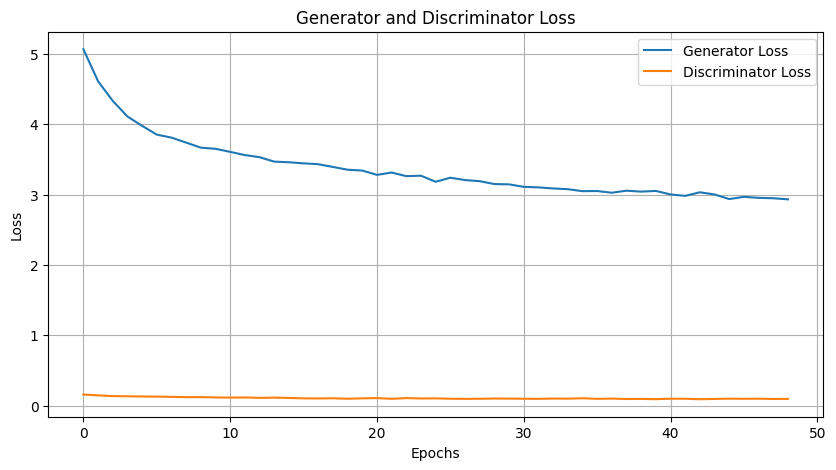

In [15]:
# Cell 5: Training Loop (Kaggle Resume-Capable Version)
import torch.optim as optim
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import random
from IPython.display import FileLink

# --- HELPER: Replay Buffer for Stability ---
class ReplayBuffer:
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

# --- KAGGLE CONFIGURATION ---
OUTPUT_DIR = '/kaggle/working/'

# FIX 1: MATCH FILENAMES EXACTLY (Standardized naming convention)
CHECKPOINT_GEN_M2S = os.path.join(OUTPUT_DIR, "gen_m2s_latest.pth.tar")
CHECKPOINT_GEN_S2M = os.path.join(OUTPUT_DIR, "gen_s2m_latest.pth.tar")
CHECKPOINT_DISC_M = os.path.join(OUTPUT_DIR, "disc_m_latest.pth.tar")
CHECKPOINT_DISC_S = os.path.join(OUTPUT_DIR, "disc_s_latest.pth.tar")

# Check device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on: {DEVICE}")

# Hyperparameters
LR = 2e-4
NUM_EPOCHS = 50 

# 1. Initialize models & optimizers
opt_gen = optim.Adam(list(gen_mild2severe.parameters()) + list(gen_severe2mild.parameters()), lr=LR, betas=(0.5, 0.999))
opt_disc = optim.Adam(list(disc_mild.parameters()) + list(disc_severe.parameters()), lr=LR, betas=(0.5, 0.999))
L1 = nn.L1Loss()
mse = nn.MSELoss()

# Scaler
use_amp = (DEVICE == 'cuda')
scaler = torch.amp.GradScaler('cuda', enabled=use_amp)

# Arrays to store loss
G_losses = []
D_losses = []
START_EPOCH = 0

# Initialize Buffers
fake_mild_buffer = ReplayBuffer()
fake_severe_buffer = ReplayBuffer()

# --- 2. RESUME LOGIC (The Safety Net) ---
if os.path.exists(CHECKPOINT_GEN_M2S) and os.path.exists(CHECKPOINT_GEN_S2M):
    print(f"=> Found checkpoint at {CHECKPOINT_GEN_M2S}. Resuming...")
    
    try:
        # Load Checkpoints
        cp_gen_m = torch.load(CHECKPOINT_GEN_M2S, map_location=DEVICE)
        cp_gen_s = torch.load(CHECKPOINT_GEN_S2M, map_location=DEVICE)
        cp_disc_m = torch.load(CHECKPOINT_DISC_M, map_location=DEVICE) 
        cp_disc_s = torch.load(CHECKPOINT_DISC_S, map_location=DEVICE)

        # Restore Weights
        gen_mild2severe.load_state_dict(cp_gen_m["state_dict"])
        gen_severe2mild.load_state_dict(cp_gen_s["state_dict"])
        disc_mild.load_state_dict(cp_disc_m["state_dict"])
        disc_severe.load_state_dict(cp_disc_s["state_dict"])
        
        # Restore Optimizers
        opt_gen.load_state_dict(cp_gen_m["optimizer"])
        opt_disc.load_state_dict(cp_disc_m["optimizer"])
        
        # Restore Epoch
        if "epoch" in cp_gen_m:
            START_EPOCH = cp_gen_m["epoch"] + 1
        else:
            print("=> Warning: Epoch not found in checkpoint. Assuming restart at 0.")
            
        print(f"=> Successfully resumed from Epoch {START_EPOCH}!")
    except Exception as e:
        print(f"=> Error loading checkpoint: {e}. Starting from scratch.")
else:
    print("=> No checkpoint found. Starting fresh.")


# --- 3. TRAINING LOOP ---
print(f"Starting training from Epoch {START_EPOCH+1} to {NUM_EPOCHS}...")

for epoch in range(START_EPOCH, NUM_EPOCHS):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    steps = 0

    for idx, (mild, severe) in enumerate(loader):
        mild, severe = mild.to(DEVICE), severe.to(DEVICE)

        # --- Train Discriminators ---
        with torch.amp.autocast('cuda', enabled=use_amp):
            fake_severe = gen_mild2severe(mild)
            fake_mild = gen_severe2mild(severe)

            # D_severe
            D_severe_real = disc_severe(severe)
            # Use Replay Buffer
            fake_severe_buf = fake_severe_buffer.push_and_pop(fake_severe)
            D_severe_fake = disc_severe(fake_severe_buf.detach())
            
            loss_D_severe = (mse(D_severe_real, torch.ones_like(D_severe_real)) + 
                             mse(D_severe_fake, torch.zeros_like(D_severe_fake))) / 2

            # D_mild
            D_mild_real = disc_mild(mild)
            # Use Replay Buffer
            fake_mild_buf = fake_mild_buffer.push_and_pop(fake_mild)
            D_mild_fake = disc_mild(fake_mild_buf.detach())
            
            loss_D_mild = (mse(D_mild_real, torch.ones_like(D_mild_real)) + 
                           mse(D_mild_fake, torch.zeros_like(D_mild_fake))) / 2

            loss_D = (loss_D_severe + loss_D_mild) / 2

        opt_disc.zero_grad()
        scaler.scale(loss_D).backward()
        scaler.step(opt_disc)
        scaler.update()

        # --- Train Generators ---
        with torch.amp.autocast('cuda', enabled=use_amp):
            # Adversarial Loss (No buffer needed here, we want D to judge current gen)
            D_severe_fake = disc_severe(fake_severe)
            D_mild_fake = disc_mild(fake_mild)
            loss_G_severe = mse(D_severe_fake, torch.ones_like(D_severe_fake))
            loss_G_mild = mse(D_mild_fake, torch.ones_like(D_mild_fake))

            # Cycle Loss
            cycle_mild = gen_severe2mild(fake_severe)
            cycle_severe = gen_mild2severe(fake_mild)
            loss_cycle = L1(mild, cycle_mild) * 10 + L1(severe, cycle_severe) * 10

            # Identity Loss
            loss_id = L1(mild, gen_severe2mild(mild)) * 5 + L1(severe, gen_mild2severe(severe)) * 5

            loss_G = loss_G_severe + loss_G_mild + loss_cycle + loss_id

        opt_gen.zero_grad()
        scaler.scale(loss_G).backward()
        scaler.step(opt_gen)
        scaler.update()

        epoch_d_loss += loss_D.item()
        epoch_g_loss += loss_G.item()
        steps += 1

    if steps > 0:
        avg_d_loss = epoch_d_loss / steps
        avg_g_loss = epoch_g_loss / steps
        D_losses.append(avg_d_loss)
        G_losses.append(avg_g_loss)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Loss D: {avg_d_loss:.4f} | Loss G: {avg_g_loss:.4f}")
    
    # --- 4. SAVING LOGIC ---
    def save_models(suffix):
        # Naming consistency (gen_m2s_{suffix}) matches the top check
        torch.save({"state_dict": gen_mild2severe.state_dict(), "optimizer": opt_gen.state_dict(), "epoch": epoch}, 
                   os.path.join(OUTPUT_DIR, f"gen_m2s_{suffix}.pth.tar"))
        torch.save({"state_dict": gen_severe2mild.state_dict(), "optimizer": opt_gen.state_dict(), "epoch": epoch}, 
                   os.path.join(OUTPUT_DIR, f"gen_s2m_{suffix}.pth.tar"))
        
        torch.save({"state_dict": disc_mild.state_dict(), "optimizer": opt_disc.state_dict(), "epoch": epoch}, 
                   os.path.join(OUTPUT_DIR, f"disc_m_{suffix}.pth.tar"))
        torch.save({"state_dict": disc_severe.state_dict(), "optimizer": opt_disc.state_dict(), "epoch": epoch}, 
                   os.path.join(OUTPUT_DIR, f"disc_s_{suffix}.pth.tar"))

    # A. Save "Latest" every single epoch
    save_models("latest")

    # B. Save Permanent Checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        save_models(f"epoch_{epoch+1}")
        print(f"=> Saved permanent checkpoint for Epoch {epoch+1}")
        # Display clickable link
        display(FileLink(f"gen_m2s_epoch_{epoch+1}.pth.tar"))

print("Training Complete!")

# Plotting
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss")
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Testing on: dataset_prognosis/mild/cropped_redrot (105).jpeg


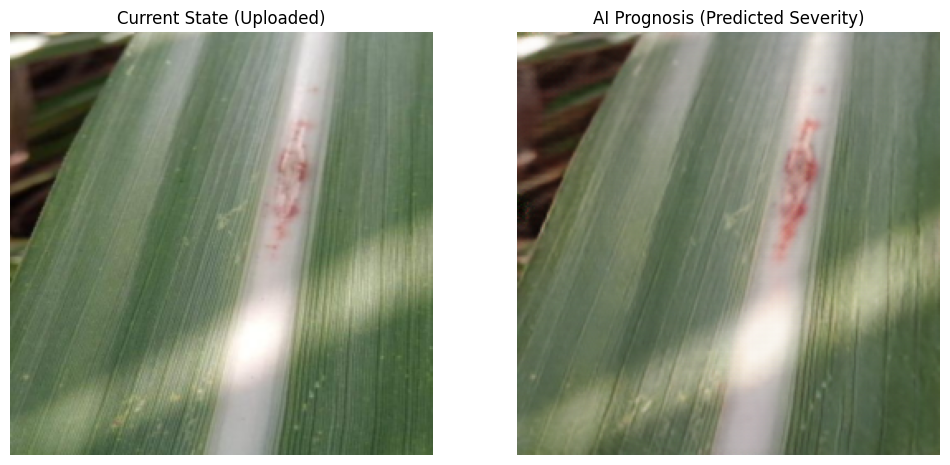

In [16]:
# Cell 6: Test Prognosis with Upload
import matplotlib.pyplot as plt
import random
from PIL import Image

# Helper function
def denormalize(img_t):
    return img_t * 0.5 + 0.5

# Pick a random mild image from the folder we created earlier
# Ensure mild_dir exists
if not os.path.exists(mild_dir):
    raise ValueError("Mild directory not found. Did Cell 2 run successfully?")

test_files = glob.glob(os.path.join(mild_dir, "*"))
if len(test_files) == 0:
    raise ValueError("No images found in mild directory.")

test_img_path = random.choice(test_files)
print(f"Testing on: {test_img_path}")

img = Image.open(test_img_path).convert("RGB")
img_t = transform(img).unsqueeze(0).to(DEVICE)

gen_mild2severe.eval()
with torch.no_grad():
    prognosis = gen_mild2severe(img_t)

    # Visualization
    img_t = denormalize(img_t.squeeze(0).cpu())
    prognosis = denormalize(prognosis.squeeze(0).cpu())

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img_t.permute(1, 2, 0))
    ax[0].set_title("Current State (Uploaded)")
    ax[0].axis("off")

    ax[1].imshow(prognosis.permute(1, 2, 0))
    ax[1].set_title("AI Prognosis (Predicted Severity)")
    ax[1].axis("off")
    plt.show()